## Convert this notebook to executable python script using:

- jupyter nbconvert --to python TrainModel.ipynb

# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import psutil
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import json
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer
import time

## User-Defined Functions

In [2]:
current_running_file_dir = sys.path[0]
current_running_file_par = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, os.path.join(current_running_file_par, 'Step1_ExtractData'))
sys.path.insert(0, os.path.join(current_running_file_par, 'Step3_TrainModel'))

In [3]:
from Extract_DFM_Data_Helper import *
from TrainModel_Helper import *

# Global Start Time and Memory

In [4]:
global_start_time = timer()
process = psutil.Process(os.getpid())
global_initial_memory = process.memory_info().rss

# Read the Input JSON File

### Input file name when using jupyter notebook

In [5]:
json_file_extract_data = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Extract/json_extract_data_000.json'
json_file_prep_data    = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Prep/json_prep_data_label_006.json'
json_file_train_model  = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Train/json_train_model_009.json'

### Input file name when using python script on command line

In [6]:
#json_file_extract_data = sys.argv[1]
#json_file_prep_data = sys.argv[2]
#json_file_train_model = sys.argv[3]

### Load the JSON file for extracting data

In [7]:
print('\nLoading the JSON file for extracting data: \n {}'.format(json_file_extract_data))


Loading the JSON file for extracting data: 
 /p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Extract/json_extract_data_000.json


In [8]:
with open(json_file_extract_data) as json_file_handle:
    json_content_extract_data = json.load(json_file_handle)

In [9]:
#json_content_extract_data

### Load the JSON file for preparing data

In [10]:
print('Loading the JSON file for preparing data: \n {}'.format(json_file_prep_data))

Loading the JSON file for preparing data: 
 /p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Prep/json_prep_data_label_006.json


In [11]:
with open(json_file_prep_data) as json_file_handle:
    json_content_prep_data = json.load(json_file_handle)

In [12]:
#json_content_prep_data

### Load the JSON file for training model

In [13]:
print('Loading the JSON file for training model: \n {}'.format(json_file_train_model))

Loading the JSON file for training model: 
 /p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/InputJson/Train/json_train_model_009.json


In [14]:
with open(json_file_train_model) as json_file_handle:
    json_content_train_model = json.load(json_file_handle)

In [15]:
#json_content_train_model

# Variables to be Used for Training Model

## DataSet Defintion

In [16]:
# The current data set params
data_set_count = json_content_extract_data['data_set_defn']['data_set_count']

## Define Label, FM Threshold etc.

In [17]:
label_count = json_content_prep_data['label_defn']['label_count']

In [18]:
FM_labels = json_content_prep_data['FM_labels']

In [19]:
FM_label_type = FM_labels['label_type']

if (FM_label_type == 'Binary'):
    FM_binary_threshold = FM_labels['FM_binary_threshold']
    class_labels = range(2)
if (FM_label_type == 'MultiClass'):
    FM_MC_levels = FM_labels['FM_MC_levels']
    class_labels = range(len(FM_MC_levels) -1)

In [20]:
FM_hr = json_content_prep_data['qoi_to_plot']['FM_hr']

## Define Training Options, ML Model, and Params etc.

### Training Options

In [21]:
train_from_scratch = json_content_train_model['train_options']['train_from_scratch']
save_train_data = json_content_train_model['train_options']['save_train_data']
save_test_data = json_content_train_model['train_options']['save_test_data']

### Model Defintion

In [22]:
model_count = json_content_train_model['models']['model_count']
scaler_type = json_content_train_model['models']['scaler_type']
model_name  = json_content_train_model['models']['model_name'] # ['RF', SVM', 'MLP']
model_params = json_content_train_model['models']['params']

### Features/Labels Options

In [23]:
qois_for_training = json_content_train_model['features_labels']['qois_for_training']
label_log = json_content_train_model['features_labels']['label_log']

In [24]:
#qois_for_training

### Evaluation

In [25]:
evaluation = json_content_train_model['evaluation']
fig_size_x = evaluation['fig_size_x']
fig_size_y = evaluation['fig_size_y']
font_size  = evaluation['font_size']

if (FM_label_type == 'Regression'):
    max_data_size_scatter = evaluation['max_data_size_scatter']
    x_lim      = evaluation['x_lim']
else:
    normalize_cm = evaluation['normalize_cm']

# Paths and File Names

#### Global

In [26]:
prepared_data_base_loc = json_content_prep_data[ 'paths']['prepared_data_base_loc']
trained_model_base_loc = json_content_train_model['paths']['trained_model_base_loc']

#### DataSet and Label Specific (Train and Test Data Prepared)

In [27]:
prepared_data_set_name = 'dataset_%03d_label_%03d_%s'%(data_set_count, \
                                                       label_count, FM_label_type)

prepared_data_loc = os.path.join(prepared_data_base_loc, prepared_data_set_name)
#os.system('mkdir -p %s'%prepared_data_loc)

prepared_data_file_name = '{}.pkl'.format(prepared_data_set_name)

#### DataSet, Label, and Model Specific (Trained Model)

In [28]:
trained_model_name = 'dataset_%03d_label_%03d_%s_model_%03d_%s'%(data_set_count, \
                                                        label_count, FM_label_type, \
                                                        model_count, model_name)

trained_model_loc = os.path.join(trained_model_base_loc, trained_model_name)
os.system('mkdir -p %s'%trained_model_loc)

trained_model_file_name = '{}_model.pkl'.format(trained_model_name)

train_data_features_file_name   = '{}_features_train.pkl'.format(trained_model_name)
train_data_labels_file_name     = '{}_labels_train.pkl'.format(trained_model_name)

train_data_scatter_file_name    = '{}_scatter_train.png'.format(trained_model_name)
train_data_cm_file_name         = '{}_cm_train.png'.format(trained_model_name)

test_data_features_file_name    = '{}_features_test.pkl'.format(trained_model_name)
test_data_labels_file_name      = '{}_labels_test.pkl'.format(trained_model_name)

test_data_scatter_file_name     = '{}_scatter_test.png'.format(trained_model_name)
test_data_scatter_file_name_p90 = '{}_scatter_test_p90.png'.format(trained_model_name)
test_data_scatter_file_name_p95 = '{}_scatter_test_p95.png'.format(trained_model_name)

test_data_cm_file_name          = '{}_cm_test.png'.format(trained_model_name)
test_data_cm_file_name_p90      = '{}_cm_test_p90.png'.format(trained_model_name)
test_data_cm_file_name_p95      = '{}_cm_test_p95.png'.format(trained_model_name)

model_eval_file_name            = '{}_eval.pkl'.format(trained_model_name)

# Generate seed for the random number generator

In [29]:
seed = generate_seed()
random_state = init_random_generator(seed)

# Load The Prepared Data Saved in Pickle File

In [30]:
if train_from_scratch:
    with open(os.path.join(prepared_data_loc, prepared_data_file_name), 'rb') as file_handle:
        prepared_data = pickle.load(file_handle)
    print('\nRead prepared data from "{}" at "{}"\n'.format(prepared_data_file_name, prepared_data_loc))


Read prepared data from "dataset_000_label_006_Regression.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/02_TrainTest_Data_Prepared/dataset_000_label_006_Regression"



# Get Features and Labels to Use

## Features

In [31]:
if train_from_scratch:
    features_in_prep_data = prepared_data['features'].keys()
    features_to_use = define_features_to_use (features_in_prep_data, qois_for_training)

In [32]:
#features_in_prep_data

In [33]:
#features_to_use

## Labels

In [34]:
#prepared_data['labels'].keys()

In [35]:
if train_from_scratch:
    if (FM_label_type == 'Regression'):
        labels_to_use = ['FM_{}hr'.format(FM_hr)]
    elif (FM_label_type == 'Binary'):
        labels_to_use = ['FM_{}hr_bin'.format(FM_hr)]
    elif (FM_label_type == 'MultiClass'):
        labels_to_use = ['FM_{}hr_MC'.format(FM_hr)]
    else:
        raise ValueError('Invalid "label_type": {} in "FM_labels". \
                        \nValid types are: "Regression", "MultiClass", and "Binary"'.format(\
                                                                                FM_label_type))

In [36]:
#labels_to_use

## Extract Features and Labels from Prepared Train/Test Data

In [37]:
if train_from_scratch:
    X_tt     = prepared_data['features'][features_to_use]
    y_tt     = prepared_data['labels'][labels_to_use]
    #idy_tt   = prepared_data['identity']
    #all_tt = prepared_data['all']

In [38]:
#X_tt, y_tt

In [39]:
#X_tt.dtypes, y_tt.dtypes

## Scale Features

In [40]:
if train_from_scratch:
    print ('Data scaler type: {}'.format(scaler_type))
    scaler = define_scaler (scaler_type)
    scaler.fit(X_tt)
    X_tt_scaled = scaler.transform(X_tt)

Data scaler type: Standard


In [41]:
#X_tt_scaled

## Modify Labels

In [42]:
if (FM_label_type == 'Regression' and label_log):
    y_tt = np.log(y_tt)

In [43]:
#plt.hist(y_tt)

#### Clarify if train/test split should be performed after or before scaling

## Train /Test Split

In [44]:
if train_from_scratch:
    test_data_frac = json_content_train_model['models']['test_data_frac']
    features_train, features_test, labels_train, labels_test = train_test_split(\
                             X_tt_scaled, y_tt.to_numpy(), test_size = test_data_frac)

In [45]:
#type(labels_test)

In [46]:
#plt.hist(labels_train), plt.hist(labels_test)

# ML Model

## Define the Model

In [47]:
print ('FM label type: {}'.format(FM_label_type))
print ('ML model considered: {}'.format(model_name))

FM label type: Regression
ML model considered: RF


In [48]:
if train_from_scratch:
    model = define_model (FM_label_type, model_name)

In [49]:
if train_from_scratch:
    print ('The model chosen is: {} \n'.format(model))
    print ('Deafult model params: \n {}'.format(model.get_params()))

The model chosen is: RandomForestRegressor() 

Deafult model params: 
 {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [50]:
if train_from_scratch and model_params != {}:
    print ('Updating the model params with the dict: \n {}'.format(model_params))
    model.set_params(**model_params)

In [51]:
if train_from_scratch and model_params != {}:
    print ('Updated model params: \n {}'.format(model.get_params()))

## Train the Model

In [52]:
if train_from_scratch:
    t0 = time.time()
    model.fit(features_train, labels_train.ravel())
    training_time = round(time.time()-t0, 3)
    print ("\nTraining Time: {} s".format(training_time))


Training Time: 7.591 s


# Prediction with Trained Model

### Load the ML Model

In [53]:
if not train_from_scratch:
    trained_model_file = os.path.join(trained_model_loc, trained_model_file_name)
    model = pickle.load(open(trained_model_file, 'rb'))
    print ('\nLoaded the ML model file at: {}\n'.format(trained_model_file))
    print ('The model loaded is: {} \n'.format(model))

## Prediction on Train Data

### Load the features and labels used in training if not training from scratch

In [54]:
if not train_from_scratch:
    print('Loading the saved features and labels used in training')
    features_train = pickle.load(open(os.path.join(\
                            trained_model_loc, train_data_features_file_name), 'rb'))
    labels_train   =  pickle.load(open(os.path.join(\
                            trained_model_loc, train_data_labels_file_name), 'rb'))

### Predict and Evaluate

In [55]:
labels_pred_train = predict(model, features_train, "Train Data")

Prediction Time for Train Data is 0.133 s


In [56]:
if (FM_label_type == 'Regression'):
    labels_error, labels_error_abs, labels_pc_err, labels_pc_err_abs = \
                                            compute_errors (labels_train, labels_pred_train)

Computing errors with ground truth and predicted labels


In [57]:
if (FM_label_type == 'Regression'):
    labels_error_p90, labels_error_p95, \
    labels_gt_best90, labels_pred_best90, \
    labels_gt_best95, labels_pred_best95 = \
            compute_best_90_95_labels (labels_train, labels_pred_train, labels_error_abs)

Computing 90-th and 95-th percentiles of error
P90: 0.0228, P95: 0.0307
Data SIZE:- Orig: 5714, Best 90%: 5142, Best 95%: 5428


Metrics for Train Data:
             ... R2: 0.9530, EV: 0.9530, MSE: 0.0002, RMSE: 0.0145, 
             ... Max_Err : 0.0866, MAE: 0.0103, MedAE: 0.0072


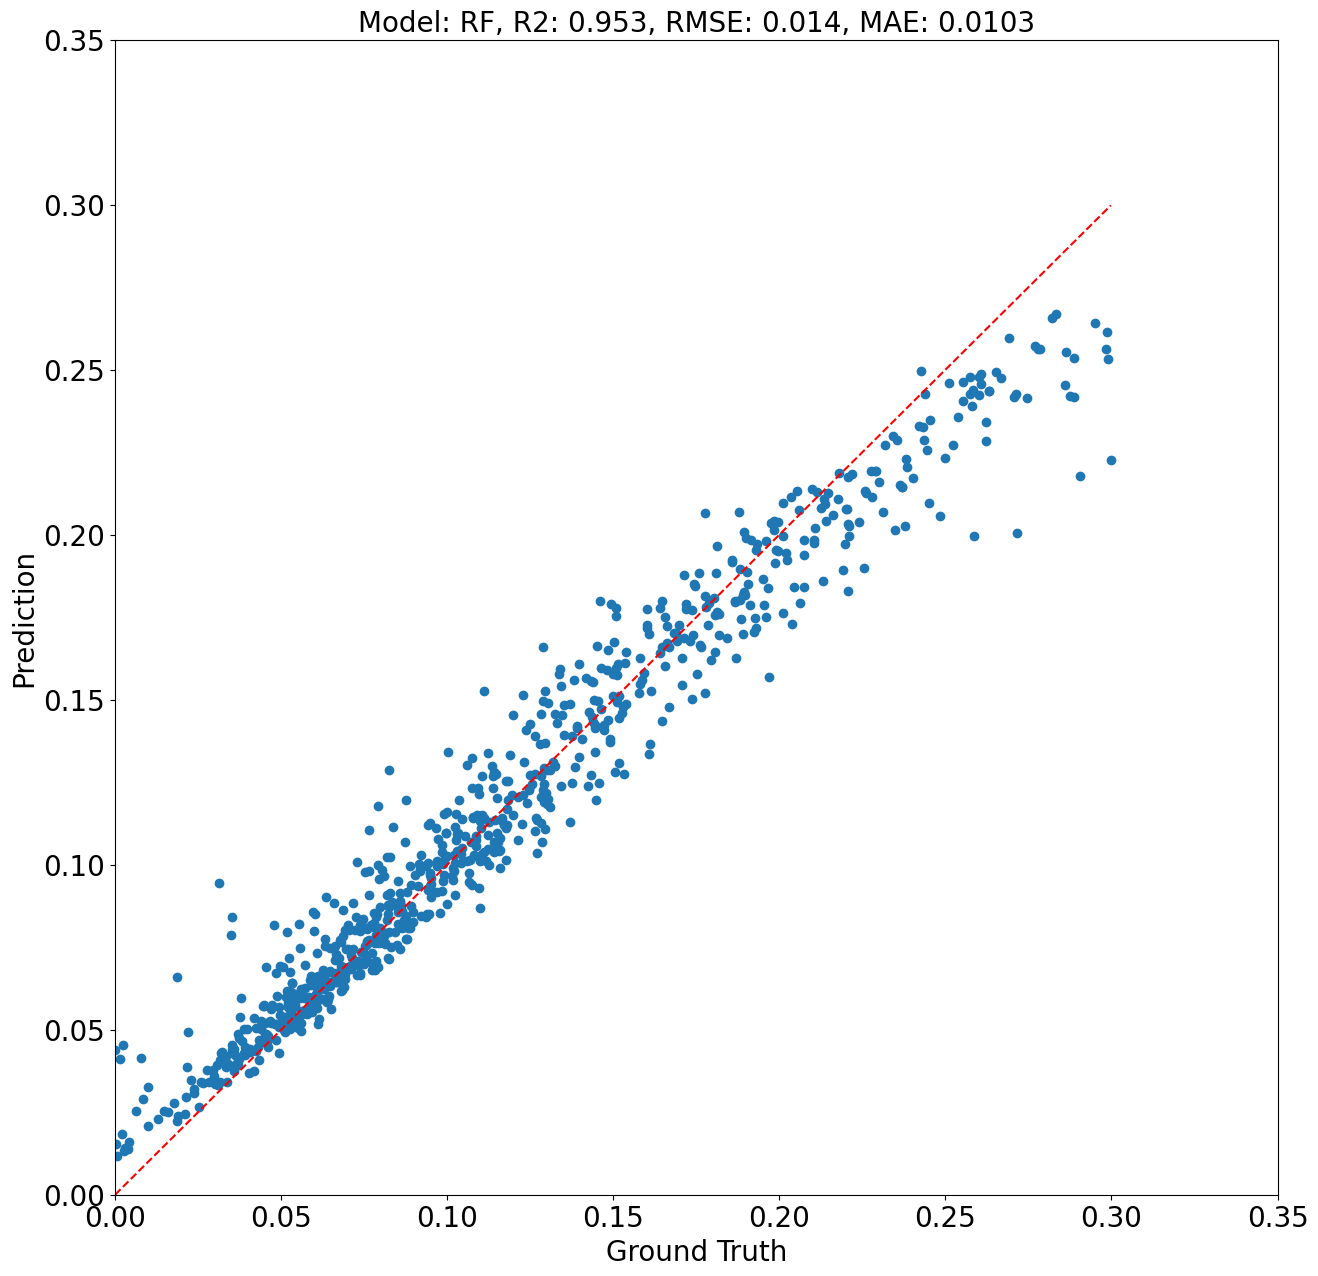

In [58]:
if (FM_label_type == 'Regression'):
    r2_score_train, ev_score_train, mse_train, rmse_train, \
    max_err_train, mae_train, medae_train = \
    get_metrics_plot_scatter_regression (labels_train, labels_pred_train, "Train Data", \
                             model_name, trained_model_loc, train_data_scatter_file_name, \
                             max_data_size_scatter, fig_size_x, fig_size_y, \
                             font_size, x_lim, label_log)

In [59]:
if (FM_label_type == 'Binary' or FM_label_type == 'MultiClass'):
    conf_mat_train = get_confusion_matrix (FM_label_type, labels_train, labels_pred_train, \
                                      "Train Data", class_labels)
    get_classification_report (FM_label_type, labels_train, labels_pred_train, \
                          "Train Data", class_labels)
else:
    conf_mat_train = None
    print('Confusion Matrix is not suitable for label_type: {}'.format(FM_label_type))

Confusion Matrix is not suitable for label_type: Regression


In [60]:
if (FM_label_type == 'Binary'):
    average_precision_train = average_precision_score(labels_train, labels_pred_train)
    print('Average precision-recall score for Train Data: {0:0.2f}'.format(
          average_precision_train))

### Plot  Confusion Matrix

In [61]:
if (FM_label_type != 'Regression'):
    plot_confusion_matrix (conf_mat_train, accuracy_train, model_name, \
                           trained_model_loc, train_data_cm_file_name, \
                           fig_size_x, fig_size_y, \
                           font_size,\
                           normalize_cm, class_labels)

## Prediction on Test Data

### Load the features and labels saved for testing if not training from scratch

In [62]:
if not train_from_scratch:
    print('Loading the saved features and labels meant for testing')
    features_test = pickle.load(open(os.path.join(\
                            trained_model_loc, test_data_features_file_name), 'rb'))
    labels_test   =  pickle.load(open(os.path.join(\
                            trained_model_loc, test_data_labels_file_name), 'rb'))

### Predict and Evaluate

In [63]:
#plt.hist(labels_error_abs, bins = 50, density=False, cumulative=False)

In [64]:
#plt.hist(labels_error_abs, bins = 50, density=True, cumulative=True)

In [65]:
labels_pred_test = predict(model, features_test, "Test Data")

Prediction Time for Test Data is 0.074 s


In [66]:
if (FM_label_type == 'Regression'):
    labels_error, labels_error_abs, labels_pc_err, labels_pc_err_abs = \
                                            compute_errors (labels_test, labels_pred_test)

Computing errors with ground truth and predicted labels


In [67]:
if (FM_label_type == 'Regression'):
    labels_error_p90, labels_error_p95, \
    labels_gt_p90, labels_pred_p90, \
    labels_gt_p95, labels_pred_p95 = \
            compute_best_90_95_labels (labels_test, labels_pred_test, labels_error_abs)

Computing 90-th and 95-th percentiles of error
P90: 0.0648, P95: 0.0823
Data SIZE:- Orig: 1429, Best 90%: 1286, Best 95%: 1357


Metrics for Test Data:
             ... R2: 0.6639, EV: 0.6640, MSE: 0.0015, RMSE: 0.0389, 
             ... Max_Err : 0.1856, MAE: 0.0283, MedAE: 0.0204


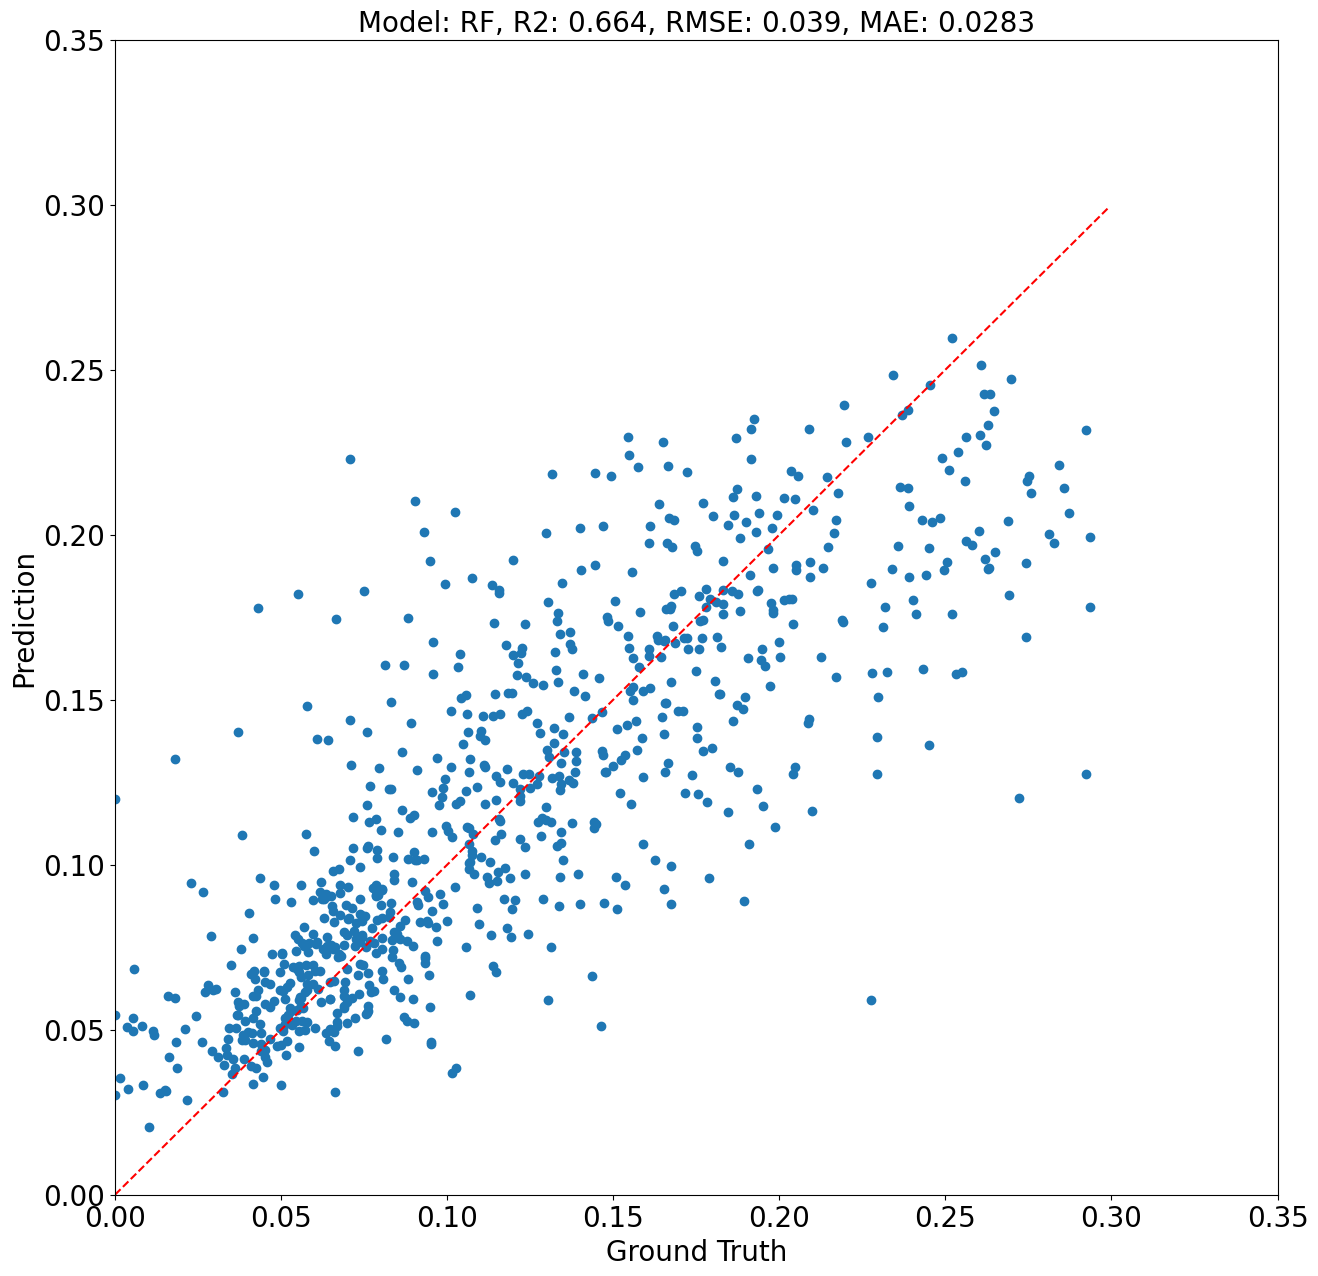

In [68]:
if (FM_label_type == 'Regression'):
    r2_score_test, ev_score_test, mse_test, rmse_test, \
    max_err_test, mae_test, medae_test = \
    get_metrics_plot_scatter_regression (labels_test, labels_pred_test, "Test Data", \
                             model_name, trained_model_loc, test_data_scatter_file_name, \
                             max_data_size_scatter, fig_size_x, fig_size_y, \
                             font_size, x_lim, label_log)

Metrics for Test Data -p90:
             ... R2: 0.8152, EV: 0.8157, MSE: 0.0007, RMSE: 0.0270, 
             ... Max_Err : 0.0648, MAE: 0.0215, MedAE: 0.0180


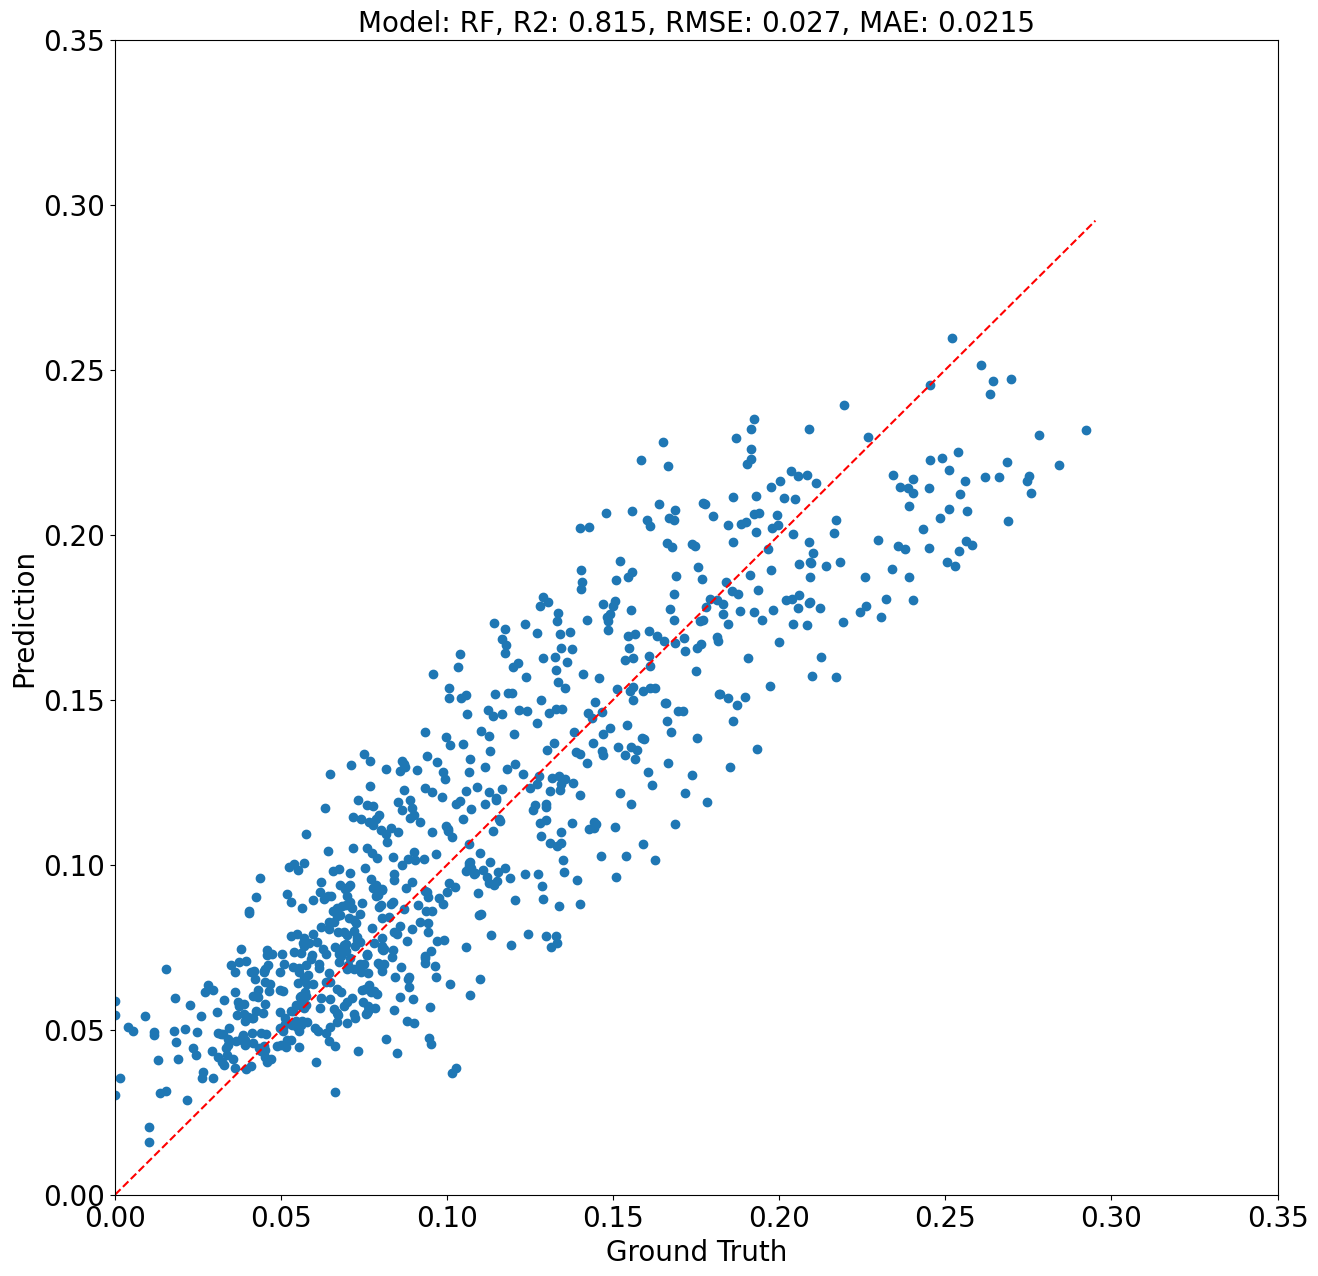

In [69]:
if (FM_label_type == 'Regression'):
    r2_score_test_p90, ev_score_test_p90, mse_test_p90, rmse_test_p90, \
    max_err_test_p90, mae_test_p90, medae_test_p90 = \
    get_metrics_plot_scatter_regression (labels_gt_p90, labels_pred_p90, "Test Data -p90", \
                             model_name, trained_model_loc, test_data_scatter_file_name_p90, \
                             max_data_size_scatter, fig_size_x, fig_size_y, \
                             font_size, x_lim, label_log)

Metrics for Test Data -p95:
             ... R2: 0.7680, EV: 0.7683, MSE: 0.0010, RMSE: 0.0311, 
             ... Max_Err : 0.0818, MAE: 0.0242, MedAE: 0.0191


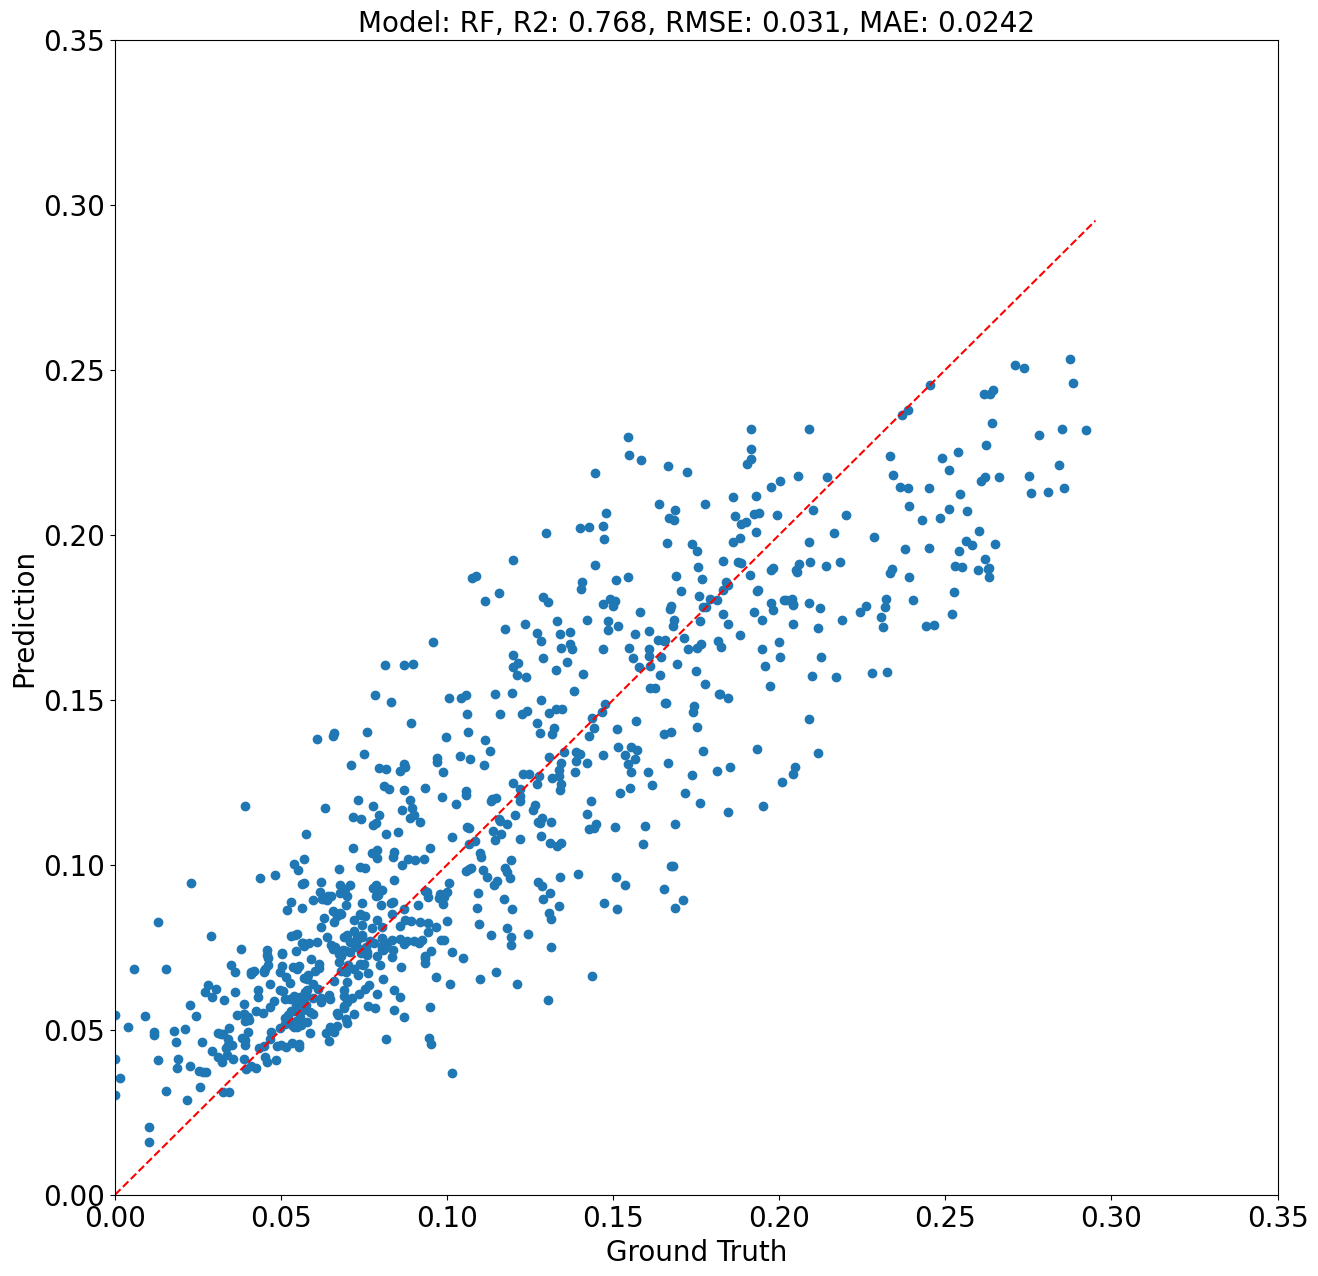

In [70]:
if (FM_label_type == 'Regression'):
    r2_score_test_p95, ev_score_test_p95, mse_test_p95, rmse_test_p95, \
    max_err_test_p95, mae_test_p95, medae_test_p95 = \
    get_metrics_plot_scatter_regression (labels_gt_p95, labels_pred_p95, "Test Data -p95", \
                             model_name, trained_model_loc, test_data_scatter_file_name_p95, \
                             max_data_size_scatter, fig_size_x, fig_size_y, \
                             font_size, x_lim, label_log)

In [71]:
if (FM_label_type == 'Binary' or FM_label_type == 'MultiClass'):
    conf_mat_test = get_confusion_matrix (FM_label_type, labels_test, labels_pred_test, \
                                      "Test Data", class_labels)
    get_classification_report (FM_label_type, labels_test, labels_pred_test, \
                          "Test Data", class_labels)
else:
    conf_mat_test = None
    print('Confusion Matrix is not suitable for label_type: {}'.format(FM_label_type))

Confusion Matrix is not suitable for label_type: Regression


In [72]:
if (FM_label_type == 'Binary'):
    average_precision_test = average_precision_score(labels_test, labels_pred_test)
    print('Average precision-recall score for Test Data: {0:0.2f}'.format(
          average_precision_test))

### Plot Confusion Matrix

In [73]:
if (FM_label_type != 'Regression'):
    plot_confusion_matrix (conf_mat_test, accuracy_test, model_name, \
                           trained_model_loc, test_data_cm_file_name, \
                           fig_size_x, fig_size_y, \
                           font_size,\
                           normalize_cm, class_labels)

# Save ML Model Evaluation Metrics

In [74]:
if (FM_label_type == 'Regression'):
    data_for_csv = {'r2_score_train': [r2_score_train],
                    'ev_score_train': [ev_score_train] ,
                    'mse_train':      [mse_train],
                    'rmse_train':     [rmse_train],
                    'max_err_train':  [max_err_train],
                    'mae_train':      [mae_train],
                    'medae_train':    [medae_train],
                    'r2_score_test':  [r2_score_test],
                    'ev_score_test':  [ev_score_test],
                    'mse_test':       [mse_test],
                    'rmse_test':      [rmse_test],
                    'max_err_test':   [max_err_test],
                    'mae_test':       [mae_test],
                    'medae_test':     [medae_test],
                    'r2_score_test_p90':  [r2_score_test_p90],
                    'ev_score_test_p90':  [ev_score_test_p90],
                    'mse_test_p90':       [mse_test_p90],
                    'rmse_test_p90':      [rmse_test_p90],
                    'max_err_test_p90':   [max_err_test_p90],
                    'mae_test_p90':       [mae_test_p90],
                    'medae_test_p90':     [medae_test_p90],
                    'r2_score_test_p95':  [r2_score_test_p95],
                    'ev_score_test_p95':  [ev_score_test_p95],
                    'mse_test_p95':       [mse_test_p95],
                    'rmse_test_p95':      [rmse_test_p95],
                    'max_err_test_p95':   [max_err_test_p95],
                    'mae_test_p95':       [mae_test_p95],
                    'medae_test_p95':     [medae_test_p95]
                   }

In [75]:
more_data_for_df = { 'conf_mat_train':    [conf_mat_train],
                     'conf_mat_test':     [conf_mat_test]
                   }

In [76]:
model_eval_csv = pd.DataFrame(data_for_csv)
model_eval_csv.to_csv(os.path.join(trained_model_loc, \
                                   model_eval_file_name.replace('pkl','csv')), index=False)

In [77]:
model_eval_df = pd.DataFrame(data_for_csv | more_data_for_df) # Merge two dicts
model_eval_df.to_pickle(os.path.join(trained_model_loc, model_eval_file_name))

In [78]:
#df_from_pickle = pd.read_pickle(os.path.join(trained_model_loc, model_eval_file+'.pkl'))
#df_from_pickle

## Save Train/Test Data

In [79]:
if train_from_scratch and save_train_data:
    pickle.dump(features_train, open(os.path.join(\
                        trained_model_loc, train_data_features_file_name), 'wb'))
    pickle.dump(labels_train, open(os.path.join(\
                        trained_model_loc, train_data_labels_file_name), 'wb'))

In [80]:
if train_from_scratch and save_test_data:
    pickle.dump(features_test, open(os.path.join(\
                        trained_model_loc, test_data_features_file_name), 'wb'))
    pickle.dump(labels_test, open(os.path.join(\
                        trained_model_loc, test_data_labels_file_name), 'wb'))

## Save the Model

In [81]:
if train_from_scratch:
    trained_model_file = os.path.join(trained_model_loc, trained_model_file_name)
    pickle.dump(model, open(trained_model_file, 'wb'))
    print ('\nSaved the ML model file at: {}\n'.format(trained_model_file))


Saved the ML model file at: /p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/03_Trained_Models/dataset_000_label_006_Regression_model_009_RF/dataset_000_label_006_Regression_model_009_RF_model.pkl



# Global End Time and Memory

In [82]:
global_final_memory = process.memory_info().rss
global_end_time = timer()
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))
print('Total computing time: {:.3f} s'.format(global_end_time - global_start_time))
print('=========================================================================')
print("SUCCESS: Done Training and Evaluation of ML Model")

Total memory consumed: 94.465 MB
Total computing time: 11.063 s
SUCCESS: Done Training and Evaluation of ML Model
